In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('train.csv')
df.head()

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0
2,1628180742,2,8.0,353733,2,8.0,1142670488,42516,Seizure,3,0,0,0,0,0
3,1628180742,3,18.0,353733,3,18.0,2718991173,42516,Seizure,3,0,0,0,0,0
4,1628180742,4,24.0,353733,4,24.0,3080632009,42516,Seizure,3,0,0,0,0,0


In [5]:
print(df.eeg_id.nunique())
print(df.spectrogram_id.nunique())

17089
11138


In [6]:
TARGETS = df.columns[-6:]
print('Train shape:', df.shape )
print('Targets', list(TARGETS))
df.head()

Train shape: (106800, 15)
Targets ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']


,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0
2,1628180742,2,8.0,353733,2,8.0,1142670488,42516,Seizure,3,0,0,0,0,0
3,1628180742,3,18.0,353733,3,18.0,2718991173,42516,Seizure,3,0,0,0,0,0
4,1628180742,4,24.0,353733,4,24.0,3080632009,42516,Seizure,3,0,0,0,0,0


In [7]:
train = df.groupby('eeg_id')[['spectrogram_id','spectrogram_label_offset_seconds']].agg(
    {'spectrogram_id':'first','spectrogram_label_offset_seconds':'min'})
train.columns = ['spec_id','min']

tmp = df.groupby('eeg_id')[['spectrogram_id','spectrogram_label_offset_seconds']].agg(
    {'spectrogram_label_offset_seconds':'max'})
train['max'] = tmp

tmp = df.groupby('eeg_id')[['patient_id']].agg('first')
train['patient_id'] = tmp

tmp = df.groupby('eeg_id')[TARGETS].agg('sum')
for t in TARGETS:
    train[t] = tmp[t].values
    
y_data = train[TARGETS].values
y_data = y_data / y_data.sum(axis=1,keepdims=True)
train[TARGETS] = y_data

tmp = df.groupby('eeg_id')[['expert_consensus']].agg('first')
train['target'] = tmp

train = train.reset_index()
print('Train non-overlapp eeg_id shape:', train.shape )
train.head()


Train non-overlapp eeg_id shape: (17089, 12)


,eeg_id,spec_id,min,max,patient_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,target
0,568657,789577333,0.0,16.0,20654,0.0,0.000000,0.25,0.000000,0.166667,0.583333,Other
1,582999,1552638400,0.0,38.0,20230,0.0,0.857143,0.00,0.071429,0.000000,0.071429,LPD
2,642382,14960202,1008.0,1032.0,5955,0.0,0.000000,0.00,0.000000,0.000000,1.000000,Other
3,751790,618728447,908.0,908.0,38549,0.0,0.000000,1.00,0.000000,0.000000,0.000000,GPD
4,778705,52296320,0.0,0.0,40955,0.0,0.000000,0.00,0.000000,0.000000,1.000000,Other


In [8]:
READ_SPEC_FILES = False
READ_EEG_SPEC_FILES = False

In [11]:
import os


# READ ALL SPECTROGRAMS
PATH = 'train_spectrograms/'
files = os.listdir(PATH)
print(f'There are {len(files)} spectrogram parquets')

if READ_SPEC_FILES:    
    spectrograms = {}
    for i,f in enumerate(files):
        if i%100==0: print(i,', ',end='')
        tmp = pd.read_parquet(f'{PATH}{f}')
        name = int(f.split('.')[0])
        spectrograms[name] = tmp.iloc[:,1:].values
else:
    spectrograms = np.load('specs/specs.npy',allow_pickle=True).item()

There are 11138 spectrogram parquets


In [16]:
if READ_EEG_SPEC_FILES:
    all_eegs = {}
    for i,e in enumerate(train.eeg_id.values):
        if i%100==0: print(i,', ',end='')
        x = np.load(f'/kaggle/input/brain-eeg-spectrograms/EEG_Spectrograms/{e}.npy')
        all_eegs[e] = x
else:
    all_eegs = np.load('eeg_specs/eeg_specs.npy',allow_pickle=True).item()

In [17]:
import warnings
warnings.filterwarnings('ignore')

# FEATURE NAMES
SPEC_COLS = pd.read_parquet(f'{PATH}1000086677.parquet').columns[1:]
FEATURES = [f'{c}_mean_10m' for c in SPEC_COLS]
FEATURES += [f'{c}_min_10m' for c in SPEC_COLS]
FEATURES += [f'{c}_mean_20s' for c in SPEC_COLS]
FEATURES += [f'{c}_min_20s' for c in SPEC_COLS]
FEATURES += [f'eeg_mean_f{x}_10s' for x in range(512)]
FEATURES += [f'eeg_min_f{x}_10s' for x in range(512)]
FEATURES += [f'eeg_max_f{x}_10s' for x in range(512)]
FEATURES += [f'eeg_std_f{x}_10s' for x in range(512)]
print(f'We are creating {len(FEATURES)} features for {len(train)} rows... ',end='')

data = np.zeros((len(train),len(FEATURES)))
for k in range(len(train)):
    if k%100==0: print(k,', ',end='')
    row = train.iloc[k]
    r = int( (row['min'] + row['max'])//4 ) 

    # 10 MINUTE WINDOW FEATURES (MEANS and MINS)
    x = np.nanmean(spectrograms[row.spec_id][r:r+300,:],axis=0)
    data[k,:400] = x
    x = np.nanmin(spectrograms[row.spec_id][r:r+300,:],axis=0)
    data[k,400:800] = x

    # 20 SECOND WINDOW FEATURES (MEANS and MINS)
    x = np.nanmean(spectrograms[row.spec_id][r+145:r+155,:],axis=0)
    data[k,800:1200] = x
    x = np.nanmin(spectrograms[row.spec_id][r+145:r+155,:],axis=0)
    data[k,1200:1600] = x

    # RESHAPE EEG SPECTROGRAMS 128x256x4 => 512x256
    eeg_spec = np.zeros((512,256),dtype='float32')
    xx = all_eegs[row.eeg_id]
    for j in range(4): eeg_spec[128*j:128*(j+1),] = xx[:,:,j]

    # 10 SECOND WINDOW FROM EEG SPECTROGRAMS 
    x = np.nanmean(eeg_spec.T[100:-100,:],axis=0)
    data[k,1600:2112] = x
    x = np.nanmin(eeg_spec.T[100:-100,:],axis=0)
    data[k,2112:2624] = x
    x = np.nanmax(eeg_spec.T[100:-100,:],axis=0)
    data[k,2624:3136] = x
    x = np.nanstd(eeg_spec.T[100:-100,:],axis=0)
    data[k,3136:3648] = x

train[FEATURES] = data
print(); print('New train shape:',train.shape)

We are creating 3648 features for 17089 rows... 0 , 100 , 200 , 300 , 400 , 500 , 600 , 700 , 800 , 900 , 1000 , 1100 , 1200 , 1300 , 1400 , 1500 , 1600 , 1700 , 1800 , 1900 , 2000 , 2100 , 2200 , 2300 , 2400 , 2500 , 2600 , 2700 , 2800 , 2900 , 3000 , 3100 , 3200 , 3300 , 3400 , 3500 , 3600 , 3700 , 3800 , 3900 , 4000 , 4100 , 4200 , 4300 , 4400 , 4500 , 4600 , 4700 , 4800 , 4900 , 5000 , 5100 , 5200 , 5300 , 5400 , 5500 , 5600 , 5700 , 5800 , 5900 , 6000 , 6100 , 6200 , 6300 , 6400 , 6500 , 6600 , 6700 , 6800 , 6900 , 7000 , 7100 , 7200 , 7300 , 7400 , 7500 , 7600 , 7700 , 7800 , 7900 , 8000 , 8100 , 8200 , 8300 , 8400 , 8500 , 8600 , 8700 , 8800 , 8900 , 9000 , 9100 , 9200 , 9300 , 9400 , 9500 , 9600 , 9700 , 9800 , 9900 , 10000 , 10100 , 10200 , 10300 , 10400 , 10500 , 10600 , 10700 , 10800 , 10900 , 11000 , 11100 , 11200 , 11300 , 11400 , 11500 , 11600 , 11700 , 11800 , 11900 , 12000 , 12100 , 12200 , 12300 , 12400 , 12500 , 12600 , 12700 , 12800 , 12900 , 13000 , 13100 , 13200 , 

In [18]:
train.head()

,eeg_id,spec_id,min,max,patient_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,...,eeg_std_f502_10s,eeg_std_f503_10s,eeg_std_f504_10s,eeg_std_f505_10s,eeg_std_f506_10s,eeg_std_f507_10s,eeg_std_f508_10s,eeg_std_f509_10s,eeg_std_f510_10s,eeg_std_f511_10s
0,568657,789577333,0.0,16.0,20654,0.0,0.000000,0.25,0.000000,0.166667,...,0.125155,0.125368,0.119683,0.115860,0.114118,0.113018,0.111462,0.108212,0.107247,0.102741
1,582999,1552638400,0.0,38.0,20230,0.0,0.857143,0.00,0.071429,0.000000,...,0.069664,0.070171,0.073458,0.079370,0.079854,0.079316,0.080199,0.080490,0.082505,0.082156
2,642382,14960202,1008.0,1032.0,5955,0.0,0.000000,0.00,0.000000,0.000000,...,0.094633,0.092275,0.088075,0.089900,0.090937,0.093975,0.098719,0.103099,0.091832,0.086322
3,751790,618728447,908.0,908.0,38549,0.0,0.000000,1.00,0.000000,0.000000,...,0.122007,0.124733,0.129360,0.127720,0.127159,0.127412,0.127140,0.127753,0.130659,0.129453
4,778705,52296320,0.0,0.0,40955,0.0,0.000000,0.00,0.000000,0.000000,...,0.074957,0.075909,0.079112,0.084647,0.085926,0.083905,0.080385,0.074955,0.072609,0.072345


In [19]:
del all_eegs, spectrograms, data

In [21]:
#!pip install catboost
import catboost as cat
from catboost import CatBoostClassifier, Pool


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


  Obtaining dependency information for catboost from https://files.pythonhosted.org/packages/e2/63/379617e3d982e8a66c9d66ebf4621d3357c7c18ad356473c335bffd5aba6/catboost-1.2.2-cp311-cp311-win_amd64.whl.metadata
   ---------------------------------------- 0.0/101.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/101.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/101.0 MB 495.5 kB/s eta 0:03:24
   ---------------------------------------- 0.1/101.0 MB 939.4 kB/s eta 0:01:48
   ---------------------------------------- 0.1/101.0 MB 853.3 kB/s eta 0:01:59
   ---------------------------------------- 0.2/101.0 MB 807.1 kB/s eta 0:02:05
   ---------------------------------------- 0.2/101.0 MB 778.2 kB/s eta 0:02:10
   ---------------------------------------- 0.2/101.0 MB 722.1 kB/s eta 0:02:20
   ---------------------------------------- 0.4/101.0 MB 998.3 kB/s eta 0:01:41
   ---------------------------------------- 0.6/101.0 MB 1.4 MB/s eta 0:01:13
   -------

In [25]:
from sklearn.model_selection import KFold, GroupKFold
import gc

all_oof = []
all_true = []
TARS = {'Seizure':0, 'LPD':1, 'GPD':2, 'LRDA':3, 'GRDA':4, 'Other':5}

gkf = GroupKFold(n_splits=3)
for i, (train_index, valid_index) in enumerate(gkf.split(train, train.target, train.patient_id)):   
    
    print('#'*25)
    print(f'### Fold {i+1}')
    print(f'### train size {len(train_index)}, valid size {len(valid_index)}')
    print('#'*25)
    
    model = CatBoostClassifier(loss_function='MultiClass')
    
    train_pool = Pool(
        data = train.loc[train_index,FEATURES],
        label = train.loc[train_index,'target'].map(TARS),
    )
    
    valid_pool = Pool(
        data = train.loc[valid_index,FEATURES],
        label = train.loc[valid_index,'target'].map(TARS),
    )
    
    model.fit(train_pool,
             verbose=100,
             eval_set=valid_pool,
             )
    model.save_model(f'CAT_v_f{i}.cat')
    
    oof = model.predict_proba(valid_pool)
    all_oof.append(oof)
    all_true.append(train.loc[valid_index, TARGETS].values)
    
    del train_pool, valid_pool, oof #model
    
    #break
    
all_oof = np.concatenate(all_oof)
all_true = np.concatenate(all_true)

#########################
### Fold 1
### train size 11392, valid size 5697
#########################
Learning rate set to 0.11336
0:	learn: 1.6802976	test: 1.6951452	best: 1.6951452 (0)	total: 2.61s	remaining: 43m 27s
100:	learn: 0.7977415	test: 1.0638510	best: 1.0638510 (100)	total: 3m 45s	remaining: 33m 29s
200:	learn: 0.6161337	test: 1.0173332	best: 1.0173332 (200)	total: 7m 33s	remaining: 30m 2s
300:	learn: 0.5035812	test: 0.9960572	best: 0.9958069 (298)	total: 11m 20s	remaining: 26m 20s
400:	learn: 0.4223543	test: 0.9867341	best: 0.9867341 (400)	total: 15m 8s	remaining: 22m 36s
500:	learn: 0.3625658	test: 0.9882438	best: 0.9867192 (401)	total: 18m 54s	remaining: 18m 50s
600:	learn: 0.3132147	test: 0.9926686	best: 0.9867192 (401)	total: 22m 46s	remaining: 15m 7s
700:	learn: 0.2750224	test: 0.9978196	best: 0.9867192 (401)	total: 26m 33s	remaining: 11m 19s
800:	learn: 0.2415199	test: 1.0032002	best: 0.9867192 (401)	total: 30m 20s	remaining: 7m 32s
900:	learn: 0.2130903	test: 1.006789

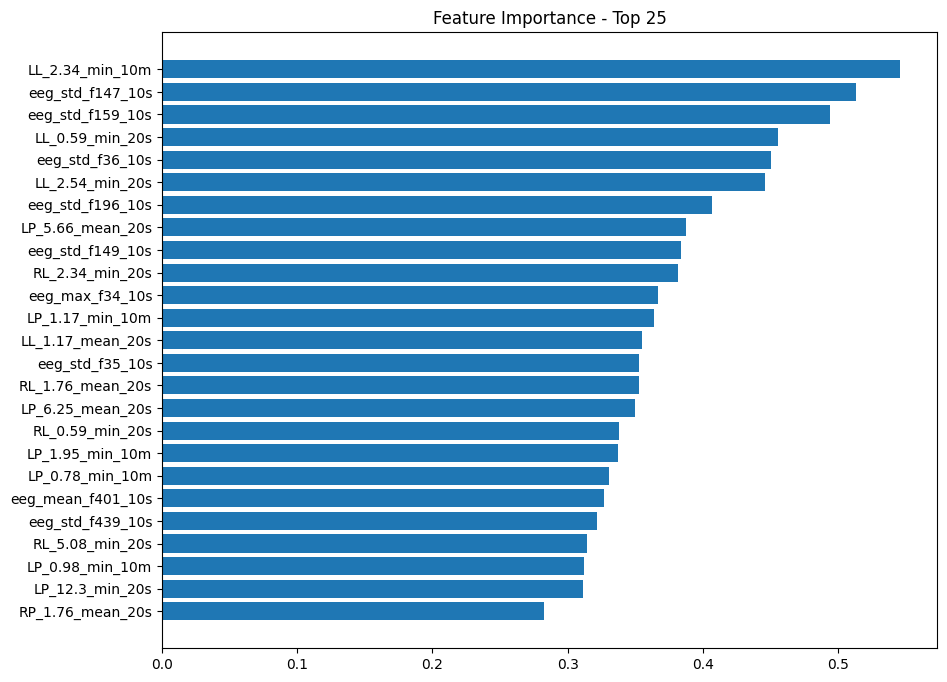

In [27]:
TOP = 25

import matplotlib.pyplot as plt

feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(10, 8))
plt.barh(np.arange(len(sorted_idx))[-TOP:], feature_importance[sorted_idx][-TOP:], align='center')
plt.yticks(np.arange(len(sorted_idx))[-TOP:], np.array(FEATURES)[sorted_idx][-TOP:])
plt.title(f'Feature Importance - Top {TOP}')
plt.show()

In [41]:
test = pd.read_csv('test.csv')
print('Test shape',test.shape)
test.head()

Test shape (1, 3)


,spectrogram_id,eeg_id,patient_id
0,853520,3911565283,6885


In [ ]:
all_eegs2 = {}
for i,e in enumerate(test.eeg_id.values):
    if i%100==0: print(i,', ',end='')
    x = np.load(f'/kaggle/input/brain-eeg-spectrograms/EEG_Spectrograms/{e}.npy')
    all_eegs[e] = x

In [44]:
PATH2 = 'test_spectrograms/'
data = np.zeros((len(test),len(FEATURES)))
    
for k in range(len(test)):
    row = test.iloc[k]
    s = int( row.spectrogram_id )
    spec = pd.read_parquet(f'{PATH2}{s}.parquet')
    
    # 10 MINUTE WINDOW FEATURES
    x = np.nanmean( spec.iloc[:,1:].values, axis=0)
    data[k,:400] = x
    x = np.nanmin( spec.iloc[:,1:].values, axis=0)
    data[k,400:800] = x

    # 20 SECOND WINDOW FEATURES
    x = np.nanmean( spec.iloc[145:155,1:].values, axis=0)
    data[k,800:1200] = x
    x = np.nanmin( spec.iloc[145:155,1:].values, axis=0)
    data[k,1200:1600] = x
    
    # RESHAPE EEG SPECTROGRAMS 128x256x4 => 512x256
    eeg_spec = np.zeros((512,256),dtype='float32')
    xx = all_eegs2[row.eeg_id]
    for j in range(4): eeg_spec[128*j:128*(j+1),] = xx[:,:,j]

    # 10 SECOND WINDOW FROM EEG SPECTROGRAMS 
    x = np.nanmean(eeg_spec.T[100:-100,:],axis=0)
    data[k,1600:2112] = x
    x = np.nanmin(eeg_spec.T[100:-100,:],axis=0)
    data[k,2112:2624] = x
    x = np.nanmax(eeg_spec.T[100:-100,:],axis=0)
    data[k,2624:3136] = x
    x = np.nanstd(eeg_spec.T[100:-100,:],axis=0)
    data[k,3136:3648] = x

test[FEATURES] = data
print('New test shape',test.shape)

KeyError: 3911565283